In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clintontrump-corpus/clinton_trump.csv


In [2]:
from fastai.imports import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path = Path('../input/clintontrump-corpus')
path.ls()

(#1) [Path('../input/clintontrump-corpus/clinton_trump.csv')]

In [4]:
df = pd.read_csv(path/'clinton_trump.csv')

In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
def extract_name(text): 
    if text.find('Trump') >= 0: return 1
    return 0

In [7]:
def extract_name_str(text): 
    if text.find('Trump') >= 0: return 'trump'
    return 'clinton'

In [8]:
df['label'] = df['doc_id'].map(extract_name).astype('float')
# df['text'] = df['doc_id'].map(extract_name_str)

In [9]:
np.mean(df['label'])

0.7008547008547008

In [10]:
df = df.drop('doc_id', axis=1)

In [11]:
df['text'] = df['text'].map(str.lower)

In [12]:
def drop_metadata(text):
    first_close = text.find('>')
    second_close = text.find('>', first_close +1 )
    return text[second_close+1:]

In [13]:
def drop_intro(text):
    first_trump = text.find('<trump')
    if (first_trump >= 0):
        return text[first_trump:]
    
    first_hilary = text.find('<hilary')
    if (first_hilary >= 0):
        return text[first_hilary:]
    return text

In [14]:
import re 

def drop_alt_speakers(text):
    return re.sub("[\(\<].*?[\)\>]", "", text)

In [15]:
def drop_incomplete_first_sen(text):
    first_stop = text.find('.')
    if (first_stop >= 0):
        return text[first_stop+2:]

In [16]:
# df['text'] = df['text'].map(drop_metadata)
# df['text'] = df['text'].map(drop_intro)
df['text'] = df['text'].map(drop_alt_speakers)
df['text'] = df['text'].str[-1200:]
df['text'] = df['text'].map(drop_incomplete_first_sen)
df['text'] = df['text'].str.replace('<applause>', '')
df['text'] = df['text'].str.replace('<cheering and applause>', '')
df['text'] = df['text'].str.replace('<crosstalk>', '')
df['text'] = df['text'].str.replace('<', '')
df['text'] = df['text'].str.replace('>', '')
df['text'] = df['text'].str.replace('\\', '')
df['text'] = df['text'].str.replace(':', ' :')   
df['text'] = df['text'].str.replace(' --', ',') 
df['text'] = df['text'].str.replace('hillary clinton', 'the candidate')
df['text'] = df['text'].str.replace('hillary', 'the candidate')
df['text'] = df['text'].str.replace('clinton', 'the candidate')
df['text'] = df['text'].str.replace('donald trump', 'the candidate')
df['text'] = df['text'].str.replace('donald', 'the candidate')
df['text'] = df['text'].str.replace('trump', 'the candidate')

In [17]:
df

,text,label
0,"can you imagine? can you imagine? you're going to look back at this rally for the rest of your life, you're going to remember this day. this is a movement like nobody has ever seen before. even bill o'reilly said it's the single greatest political phenomena of his lifetime, that's good. that's good. and many others, and many that dislike me say the same thing. we're going to make history together, you're going to look back at this election and say this is by far the most important vote that you've ever cast for anyone at anytime. a vote for the candidate is a vote for change, and a vote...",1.0
1,"but peace will require new approaches, not relying on the same failed voices of the past. these are failed voices. and now they want another four years. and we need to fix the v.a., so we never break our sacred commitment to our veterans, never ever again. we can do all of these things. we simply need to stop relying on the politicians who created these problems in the first place. they are not going to do anything. i call them all talk, no action. that's what they are. they are politicians. all talk, no action. we can't fix a rigged system by electing the people who rigged it in the firs...",1.0
2,"om or you could text ""join,"" j-o-i-n, to 47246 because we want to win ohio. but you know, we don't want to just win it for the sake of winning it, we want to win it so that we can go onto the white house next january and get to work for you. we want to win it so we can take all the plans and all the ideas that will improve your lives, that will get the economy working for everybody, not just those at the top, which will help make education affordable so college is within reach of everyone, and help you pay back your student debt. we want to defeat isis, keep our alliances strong. we want...",0.0
3,"we're going to take care of our miners. they're amazing people. american workers will be hired to do the job. we will put new american steel into the spine of our country. i will fight for every neglected part of this nation. and i will fight to bring us all together as one people. imagine what our country could accomplish if we started working together as one people under one god, saluting one flag. it's time to break with the bitter failures of the past and to embrace a new, inclusive and prosperous american future. we're not prosperous anymore. we owe $20 trillion. we have a preside...",1.0
4,"assimilation is not an act of hostility, but an expression of compassion. our system of government and our american culture is the best in the world and will produce the best outcomes for all who adopt them. thank you. this approach will not only make us safer, but bring us closer together as a country. renewing the spirit of americanism will help heal the divisions in our country of which there are so many. we have a divider as president. we call him the great divider. it's the thing he does best. he will do so by emphasizing what we have in common, not what pulls us apart. this is my ...",1.0
...,...,...
112,"we're going to take care of that. we're going to take care of that situation so quickly and you're going to be so happy and you're going to know you're going to have your company here for a long time, believe me. in this new future we are going to raise your wages. you're going to have competition. people are going to be looking for employees. they're going to be looking. companies, companies are going to be looking for people to work in that company. right now you can't get a job. and all our good jobs are gone. household incomes are over $4,000 less today than they were 16 years ago. th...",1.0
113,"no, it's going to be very, very hard. we're going to have strong borders, we're going to have the wall. mexico is going to pay for the wall 100 percent, 100 percent. we are going to get rid of obamacare. we're going to get rid of common core, we're going to bring our education, local. we're going to have local education. we're goin

In [18]:
df['text'][0]

"can you imagine?  can you imagine? you're going to look back at this rally for the rest of your life, you're going to remember this day. this is a movement like nobody has ever seen before. even bill o'reilly said it's the single greatest political phenomena of his lifetime, that's good.  that's good. and many others, and many that dislike me say the same thing. we're going to make history together, you're going to look back at this election and say this is by far the most important vote that you've ever cast for anyone at anytime.  a vote for the candidate is a vote for change, and a vote for me is really a vote for you; you're voting for you, believe me.  it's the way i look at it.  you're voting to believe in yourselves, you're voting to believe in your country. all together, we are going to make america wealthy again. we're going to make america strong again. we're going to make america safe again. we're going to make america great again. i love you, thank you, god bless you. god 

In [19]:
from sklearn.model_selection import train_test_split

df, eval_df = train_test_split(df, test_size=0.2)
df = df.reset_index(drop=True)
eval_df = eval_df.reset_index(drop=True)

In [20]:
df

,text,label
0,"bernie sanders said she has bad judgment. i said, thank you bernie, i'm going to be using that for about six months after they take. look what happened with wikileaks. they took the election away from the guy. how could he be supporting her? they took that election away. it was a rigged system. the whole system is rigged. and that's why when the media does what they're doing now, that's rigging the system, folks. it's rigging the system. the election is rigged. it's rigged like you've never seen before. they're rigging the system. these are very dishonest people. so folks, i love the peop...",1.0
1,"now i've told the president that when he hands off the baton, he's going to have to bend over. he's a lot taller than i am. but i'm excited about what we can do. i know this is been a tough campaign. i've got people coming up to me saying they've got migraines they never had before. they have stomachaches that they don't know what they're going to do with. i get it. it has been in many ways a really tough campaign. but i'll tell you what. michigan, you can make the difference. all i'm asking you is, talk to your friends, talk to your family, talk to your coworkers, talk to everybody. if ...",0.0
2,"don't disappoint us, philadelphia. we'll do great things for philadelphia. but there's so much about pennsylvania that's so important. and get out november 8th and vote. we are fighting for every parent who lost their child to gangs and drugs and violence. we are fighting for every community who's jobs have been ripped out and shift to other countries. and we are fighting for every american who believes government should serve the people not the donors and not the special interests. i'm asking you to dream big because with your vote, can you believe this? we're just four days away. you ...",1.0
3,"i wish you all could have heard her. gwen was as eloquent as any preacher. she recalled the pain of losing her son. she said at first, she couldn't even get out of bed. but, then she said, the lord talked to me, and told me, are you going to lay here and die like your son or are you going to get up and uplift his name? she realized in that moment that none of us can rest as long as there are others out there to be saved. and, that her voice could move people to action. and, then she said this, i had to turn my sorrow into a strategy, my morning into a movement. gwen hasn't stopped working ...",0.0
4,"you're going to think back to this day and you're going to say that was a great day. that was a beautiful day. i even like mr. the candidate's plane, made in america by the way, it was great, made in america. and they don't make them like that anywhere else. but you are going to say this was a very, very important day because it led to your vote on november 8th or whenever you do it, before that is fine, just as long as you do it, do it any time you want, but do it. and our country started winning again. we started winning with trade. we started doing things properly. we built up our milit...",1.0
...,...,...
88,"they're voting in numbers like they've never seen in texas, in florida. no matter where you look, they're voting in number like they've never seen before. we are fighting for every citizen who believes that government should serve the people, not the donors and not the special interests. and we are fighting to bring us all together as americans, just imagine what our country could accomplish if we started working together as one people under one god, saluting one american flag. thank you. thank you. thank you, everybody. such a great honor, incredible people. you're incredible people. ...",1.0
89,"but in arkansas, what do i have? a 25 point lead. i think i have a 25 point lead. you know she is from arkansas, but she's really from illinois. i'm a real new yorker folks. i will say this. you will never get more of a new yorker if you want a president than you're getting with me. so, i want to thank mike, i want to thank the con

In [21]:
eval_df['text'][1]

"and the main reason america is great, is because american is good. we are a big hearted, generous people; not a small kinded people. we know that if everybody works together, we will get further together, than if we separate people, we push them down, we engage in all the negativity we've heard too much about in this campaign. but sometimes, the fate of even the greatest nations lies in the balance. and, for america, this is one of these make or break elections, it really is in your hands. and i hope you will think about how you will feel the day after the election on november the 9th. are we going forward together, or are we going to be pulled backwards by someone who wants to bully us?  and i hope, i hope you will think about how together, we can make a difference. i want to be your partner, as well as your president. i want us to create the best possible future for our children and out grandchildren. that is what i will work my heart out to do, and i hope you will help me to make a

In [22]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer


In [23]:
!pip install -q datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [24]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [25]:
model_nm = 'microsoft/deberta-v3-small'

In [26]:
tokz = AutoTokenizer.from_pretrained(model_nm)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [27]:
ds = Dataset.from_pandas(df)

In [28]:
def tok_func(x): return tokz(x["text"])

In [29]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [30]:
tok_ds = tok_ds.remove_columns(['text'])

In [31]:
tok_ds

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 93
})

In [32]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 69
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 24
    })
})

In [33]:
np.mean(df['label'])

0.7096774193548387

In [34]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [35]:
! pip install -q evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
import evaluate

accuracy = evaluate.load("accuracy")

In [37]:

def acc(eval_pred):
    predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=0)
    return accuracy.compute(predictions=predictions, references=labels)

In [38]:
corr([[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0], [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0]])

{'pearson': 0.6666666666666667}

In [39]:
lr,bs = 8e-5,128
wd,epochs = 0.01,4

In [40]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=acc)

In [41]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

In [42]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
               tokenizer=tokz, compute_metrics=corr)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

In [43]:
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.617376,-0.249230
2,No log,0.617376,-0.249230
3,No log,0.617376,-0.249230
4,No log,0.394650,0.519748


In [44]:
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [45]:
eval_ds

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 24
})

In [46]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([0.32836914, 0.32421875, 0.32373047, 0.32055664, 0.32543945,
       0.33105469, 0.32397461, 0.32714844, 0.33056641, 0.32592773,
       0.32739258, 0.32910156, 0.32714844, 0.32885742, 0.32666016,
       0.32983398, 0.32641602, 0.32373047, 0.32861328, 0.32373047,
       0.32910156, 0.32250977, 0.32373047, 0.32543945])

In [47]:
preds.round()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [48]:
eval_df['label']

0     1.0
1     0.0
2     1.0
3     0.0
4     0.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    0.0
15    1.0
16    1.0
17    0.0
18    1.0
19    0.0
20    1.0
21    0.0
22    0.0
23    1.0
Name: label, dtype: float64

In [49]:
np.corrcoef(preds, eval_df['label'])

array([[1.        , 0.67535813],
       [0.67535813, 1.        ]])

In [50]:
import matplotlib as plt

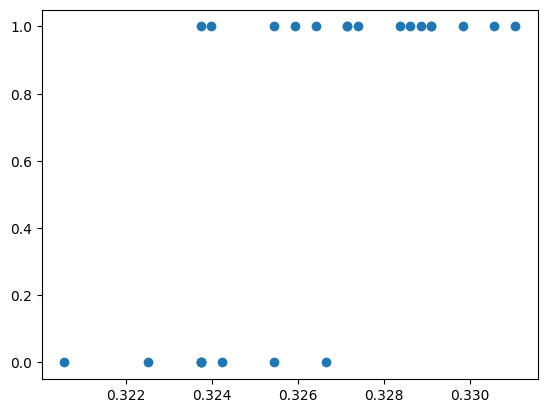

In [51]:
plt.pyplot.scatter(preds, eval_df['label'])